In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import mygene
from scipy import stats
import numpy as np
mg = mygene.MyGeneInfo()

SAMPLE_ANNOTATION = "../data/annotation/GTEx_Data_V6_Annotations_SampleAttributesDS.txt"
EXON_EXPR_DATA = "../data/GTEx_Analysis_v6_RNA-seq_RNA-SeQCv1.1.8_exon_reads.txt"
EXON_REF = "../data/gencode.v19.genes.patched_contigs_exons.txt"
PHENOTYPE_ANNOTATION = "../data/annotation/GTEx_Data_V6_Annotations_SubjectPhenotypesDS.txt"

GENE_SYMBOL = "TSPAN6"
TISSUES = ["Colon - Transverse", "Cells - Transformed fibroblasts", "Nerve - Tibial"]
MIN_THRESHOLD = 20

In [18]:
exon = pd.read_table(EXON_EXPR_DATA, nrows=50)


# Convert ensemble gene id to gene symbol
exon["ensemblGeneId"] = exon.apply(lambda row: row["Id"].split(".")[0], axis=1)

missing_symbol_count = 0
def convertToSymbol(row):
    d = mg.getgene(row["ensemblGeneId"])
    if(d == None):
        global missing_symbol_count
        missing_symbol_count += 1
        return None
    return d["symbol"]

exon["symbol"] = exon.apply(convertToSymbol, axis=1)
print("missing {} of gene_id -> symbol conversion".format(missing_symbol_count))
exon



JSONDecodeError: ('Expecting value: line 1 column 1 (char 0)', 'occurred at index 0')

In [ ]:
# Join exon reference table with exon expression table
exon_ref = pd.read_table(EXON_REF)

exon_ref["Id"] = exon_ref["Gene"]
del exon_ref["Gene"]

exon = exon.set_index('Id').join(exon_ref.set_index('Id')).reset_index()

# Create a exon_count column  
exon["exon_count"] = exon.groupby("ensemblGeneId")["ensemblGeneId"].transform('count')
exon


In [ ]:
# Get proper exon number based on strand +/-
# Given id = ENSG00000000003.10_0, exon_num = 0
# if strand -> + : exon += 1
# if strand -> - : exon = exon_count - exon_num
def getProperExonNumber(row):
    if(row.strand == "+"):
#         print("pos strand {} {}".format(row.Id, row.strand))
        return int(row.Id.split("_")[1]) + 1;
    elif(row.strand == "-"):
#         print("neg strand {} {}".format(row.Id, row.strand))
        return row.exon_count - int(row.Id.split("_")[1])
    else:
        raise Exception("invalid strand value (not +/-)")
        
exon["exon"] = exon.apply(getProperExonNumber, axis=1)
exon

In [19]:
# Extract exon read counts with given arbitrary GENE_SYMBOL

# subset based on symbol 
df = exon.loc[
    (exon["symbol"] == GENE_SYMBOL)
]

df_t = df.transpose() 

# save gene specific metadata to dataframe._metadata
genedata = {}
genedata["gene_symbol"] = GENE_SYMBOL
genedata["ensembl_id"] = df.ensemblGeneId[0]
genedata["chr"] = df.CHR[0]

# Drop irrelevant rows
df_t.columns = df_t.loc["exon"]
df_t = df_t.drop(["ensemblGeneId", 
           "symbol", 
           "CHR", 
           "start", 
           "stop", 
           "strand", 
           "exon_count", 
           "exon", 
           "Id"])
print(genedata)
df_t

KeyError: 'symbol'

In [20]:
# Group gene-specific exon expression by tissue type 
# End result a 53 (SMTSD) x ~10 (exon_counts), each cell holds an array 


# merge with sample annotation (specifically SMTSD, tissue type detail)
smp_anno = pd.read_table(SAMPLE_ANNOTATION)
smp_anno_extr = smp_anno[["SAMPID", "SMTSD"]]
df_tissue = df_t.join(smp_anno_extr.set_index('SAMPID')).set_index("SMTSD")

# populate list by tissue type
# all_tissue_expr = { exon_num: {tissueType: [ expr...], ...} }
all_tissue_expr = {}
for col in df_tissue.columns:
    cur_tissue_expr = df_tissue.groupby(df_tissue.index)[col].apply(lambda x: list(x)).to_dict()
    all_tissue_expr[col] = cur_tissue_expr

genedata["exon_expression"] = all_tissue_expr
genedata

{'chr': 'X',
 'ensembl_id': 'ENSG00000000003',
 'exon_expression': {1: {'Adipose - Subcutaneous': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.3,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.05,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    

In [21]:
# Pre-process data for bar plots


def subsetBasedOnTissue(data, tissues):
    """ extract expression data for one gene
    given a list of tissues in interest 
        
        @param data: pre-computed data (per gene)
        @param tissues: [tissueType: str]
        @rType:            
            [{tissueType: {indexas(exon_num): [expr...]}}...]
    """
    expr = genedata["exon_expression"]
    
    ret = []
    
    for tissue in tissues:
        cur_tissue_expr = {}
        for exon_num in expr:
            cur_tissue_expr[exon_num] = expr[exon_num][tissue]
        ret.append({tissue: cur_tissue_expr}) 
    return ret


subs = subsetBasedOnTissue(genedata, TISSUES)



# plotd: [ each tissue:{means:[], exons: []}, ... ]
plotd = []

for t in subs:
    tissue_expression = t.values()
    exons = []
    means = []
    stdevs = []
    for exons_expr in tissue_expression:
        # k: {indexas(exon_num): [expr...]}
        for exon_num in exons_expr.keys():
            exons.append(exon_num)
            means.append(np.mean(exons_expr[exon_num]))
            stdevs.append(np.std(exons_expr[exon_num]))
    plotd.append({
            "mean": means,
            "exon": exons,
            "stdev": stdevs
        })
print(plotd)
 

[{'mean': [2119.1016326530616, 315.78137755102046, 206.69045918367348, 344.7464795918367, 234.44576530612244, 174.6706632653061, 329.77596938775514, 299.05612244897958, 0.0012244897959183673], 'exon': [9, 8, 7, 6, 5, 4, 3, 2, 1], 'stdev': [1503.4353729567288, 227.78810742961903, 150.15316046370162, 253.3139916439807, 171.26483710171078, 127.12164782997843, 242.47254249051662, 191.44370988719572, 0.0098213954412375223]}, {'mean': [701.93806338028173, 118.59616197183098, 79.700598591549294, 143.44985915492956, 104.93538732394367, 85.672887323943669, 165.33323943661972, 120.32359154929578, 0.0], 'exon': [9, 8, 7, 6, 5, 4, 3, 2, 1], 'stdev': [284.71855345182581, 44.033007102569002, 28.433566455902987, 52.591473743788001, 38.87227216358518, 29.646579347632557, 52.653760509996609, 41.085583706565792, 0.0]}, {'mean': [1366.6809539473684, 168.02625, 111.27065789473684, 184.88967105263157, 127.32036184210526, 93.938421052631568, 167.88092105263158, 243.87822368421052, 0.01980263157894737], 'exo

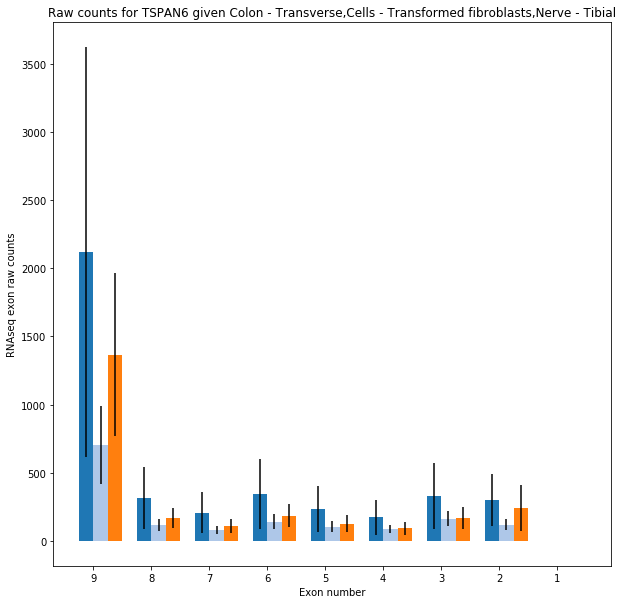

In [23]:
# Plotting barplot y-axis: raw counts, x-axis: exon number for GENE_SYMBOL given TISSUES

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
            (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
            (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
            (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
            (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.) 

num_of_exons = len(plotd[0]["mean"])

fig, ax = plt.subplots()
fig.set_size_inches((10,10))

width = 0.25

ticks = []
ind = np.empty(num_of_exons)

for i, tissue in enumerate(plotd):
    ind = np.arange(len(tissue["mean"]))
    
    ax.bar(ind + width*i, tissue["mean"], width, color=tableau20[i%20],yerr=tissue["stdev"])
    ticks = tissue["exon"]
    
ax.set_title("Raw counts for {} given {}".format(GENE_SYMBOL, ",".join(TISSUES)))
ax.set_ylabel("RNAseq exon raw counts")
ax.set_xlabel("Exon number")

plt.xticks(ind + width / 2, ticks)

plt.show()
